In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier

import shap

# load JS visualization code to notebook
shap.initjs()

import itertools

import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [2]:
df = pd.read_csv("air_train.csv")
print(df.shape)
df.drop(columns=['Unnamed: 0', 'id'], inplace=True)
df.head(3)

(103904, 25)


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

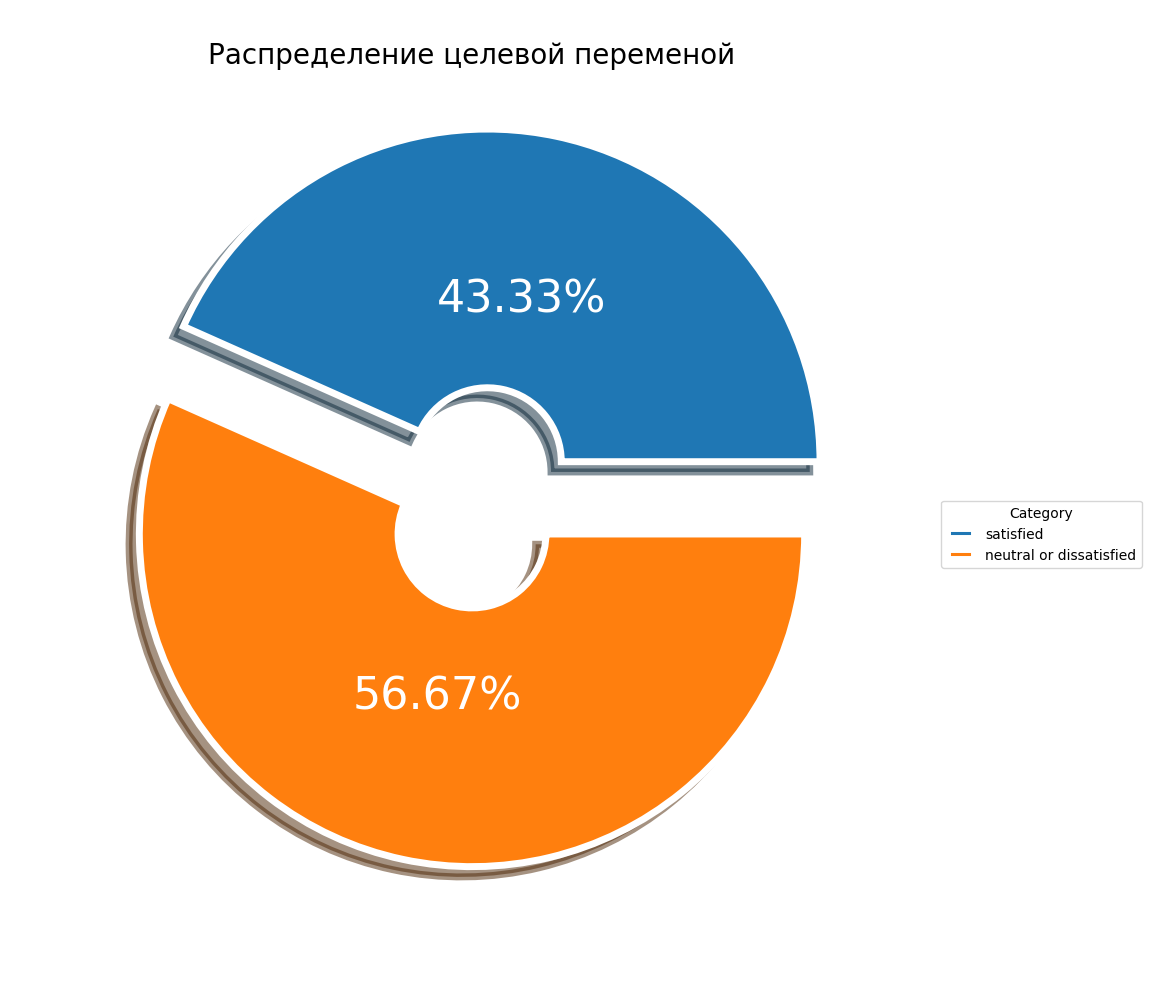

In [4]:
plt.subplots(figsize=(12, 12))

labels = "satisfied","neutral or dissatisfied"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df[df["satisfaction"]=="satisfied"]["satisfaction"]),
                                    len(df[df["satisfaction"]=="neutral or dissatisfied"]["satisfaction"])],
                                    explode = (0.2,0),
                                    textprops=dict(size= 32, color= "white"), # размер и цвет текста внутри диаграмы
                                    autopct="%.2f%%",
                                    pctdistance = 0.5, # положение текста значение процентов
                                    radius=0.9, 
                                    shadow = True, # добовляет эфект тени к диаграме
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5), # круг добовляет в центре
                                    startangle = 0)

plt.legend(wedges, labels, title="Category",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nРаспределение целевой переменой",fontsize=20)
plt.show()

In [5]:
cat_col = ['Class', 'Customer Type', 'Type of Travel', 'Gender']
num_col = [el for el in df.columns if df[el].dtype != object]

In [6]:
df['satisfaction'].replace({'neutral or dissatisfied': 0,'satisfied':1}, inplace=True);

In [7]:
df=pd.get_dummies(df, columns=cat_col, drop_first=True)

In [8]:
target = 'satisfaction'
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), df[target], stratify=df[target], random_state=10)

In [9]:
cat = CatBoostClassifier(silent=True)
cat.fit(X_train,y_train);

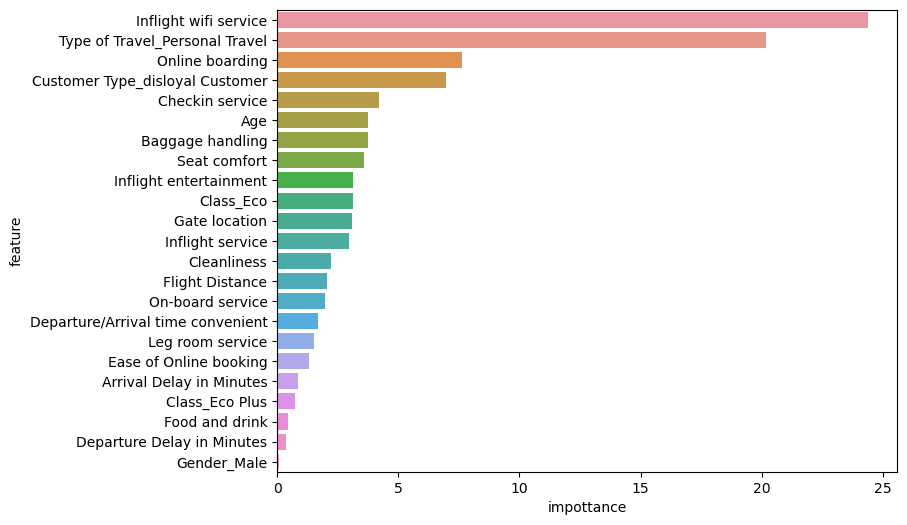

In [10]:
f_importance = pd.DataFrame(zip(X_train.columns, cat.feature_importances_), columns=['feature', 'impottance'])
f_importance.sort_values(by='impottance', ascending=False, inplace=True)
f_importance
plt.figure(figsize=(8, 6))
sns.barplot(x = f_importance['impottance'], y = f_importance['feature']);

In [12]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_train)

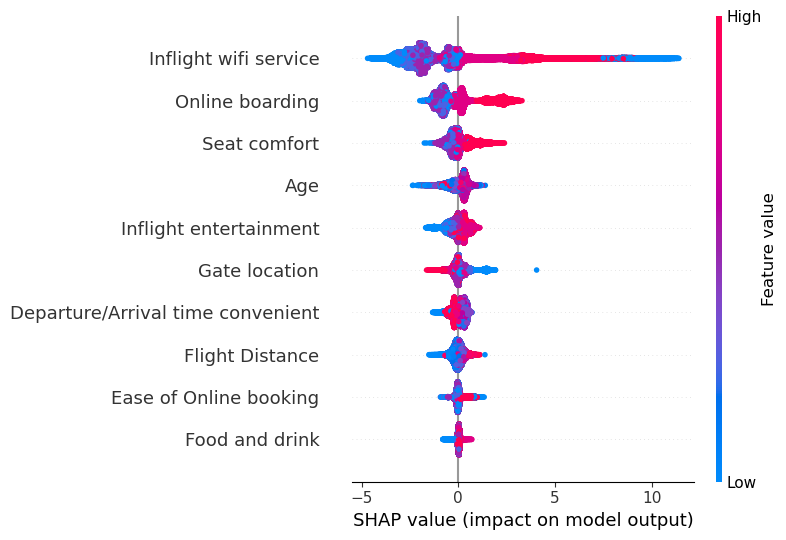

In [15]:
shap.summary_plot(shap_values[:,0:10], X_train.iloc[:,0:10]);

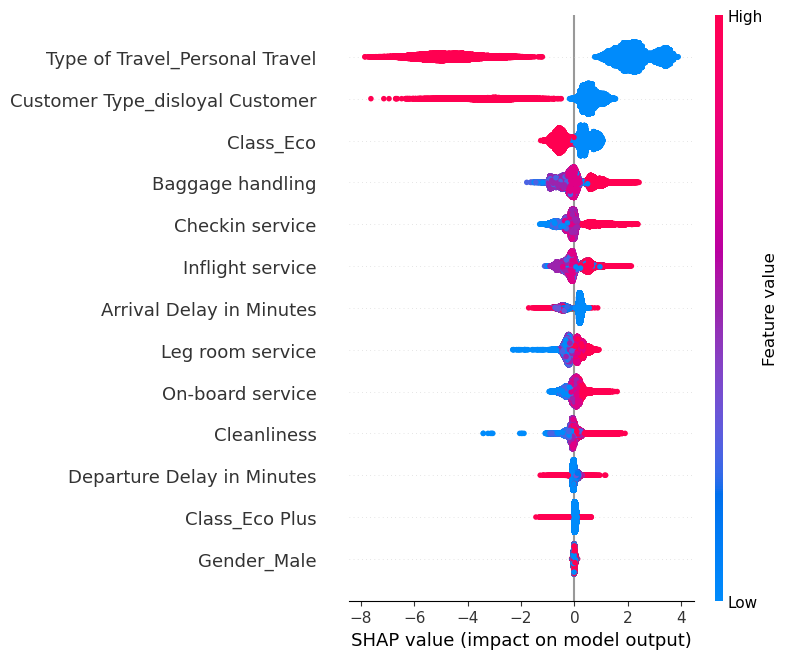

In [16]:
shap.summary_plot(shap_values[:,10:23], X_train.iloc[:,10:23]);

З признака:
* Customer Type_disloyal Customer
* Type of Travel_Personal Travel
* Class_Eco 

Обладают хорошей разделяющие силой, а так же практический не имеют зон неопределености 
(где в зависимости от статуса пользователя присутсвуют как значения положительного так и значения отрицательного класса (смесь красного и синего))  

Признаки Inflight wifi service и Online boarding тоже неплохо разделяют множество на положительный и отрицательный кклас,
однако данные признаки имеют области неопределености и не так чисто разделяют класы.  

Как не странно признаки связаные с задержкой рейса не влияют на статус удовлетворенности пользователя

In [17]:
matplotlib=True
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [18]:
matplotlib=True
shap.force_plot(explainer.expected_value, shap_values[19,18:22], X_train.iloc[1,18:22])

Для пользователя с id = 19 решающим признаком для отнесения к классу не удовлетвореных пользователей являются признак с наибольшим скором Customer Type_disloyal Customer

In [19]:
shap.force_plot(explainer.expected_value, shap_values[99,18:22], X_train.iloc[1,18:22])

ля пользователя с id = 99 решающим признаком для отнесения к классу удовлетвореных пользователей являются признак с наибольшим скором Type of Travel_Personal Travel